# Chapter 3 Linear Models for Regression
The linear regression model aims to model the predictive distribution $p(t|\mathbf{x})$ because this expresses our uncertainty about the value of $t$ for each value of $\mathbf{x}$. We can make predictions of $t$, for any new value of $\mathbf{x}$, in such a way as to minimize the expected value of a suitablly chosen loss function. 

## 3.1 Linear Basis Function Models
$\phi(\mathbf{x})$ are known as *basis functions* (usually nonlinear), which maps $\mathbf{x}$ to a vector in the feature space.
$$y(\mathbf{x},\mathbf{w}) = \mathbf{w}^\top\phi(\mathbf{x})$$
where $\mathbf{w} = (w_0,\cdots,w_{M-1})^\top$ and $\phi = (\phi_0,\cdots,\phi_{M-1})^\top$.

As before, we assume that the target variable $t$ is given by a deterministic function $y(\mathbf{x},\mathbf{w})$ (in Chapter 1, we used $y(x) = \sin(2\pi x)$) with additive Gaussian noise so that
$$t = y(\mathbf{x,\mathbf{w}})+\epsilon$$
where $\epsilon$ is a zero mean Gaussian random variable with precision (inverse variance) $\beta$. Thus we have
$$p(t|\mathbf{x},\mathbf{w},\beta) = \mathcal{N}(t|y(\mathbf{x},\mathbf{w}),\beta^{-1})$$
The optimal estimator of $t$ which minimizes the RMSE is $y(\mathbf{x},\mathbf{w})$.

Consider a data set of inputs $\mathsf{X} = \{\mathbf{x}_1,\cdots,\mathbf{x}_N\}$ with corresponding target values $\mathsf{t} = t_1,\cdots,t_N$. Clarification on notation:

one sample point
$$\mathbf{x}$$
a collection of samples (each sample might be a vector, indexed by $1,\cdots,N$)
$$\mathsf{X} = \{\mathbf{x}_1,\cdots,\mathbf{x}_N\}$$
a vector of targets (each target is a scalar)
$$\mathsf{t} = [t_1,\cdots,t_N]^\top$$
Case: No regularization
$$E(\mathbf{w}) = \frac{1}{2}\sum_{n=1}^N [\mathbf{w}^\top\phi(\mathbf{x}_n)-t_n]^2$$
The design matrix is a matrix $\Phi\in \mathbb{R}^{N\times M}$ (N data samples, M feature dimension). We can rewrite this loss function in terms of the design matrix.
\begin{equation*}
\Phi = \left[\begin{matrix}
\phi_0(\mathbf{x}_1) & \phi_1(\mathbf{x}_1) & \cdots & \phi_{M-1}(\mathbf{x}_1) \\
\phi_0(\mathbf{x}_2) & \phi_1(\mathbf{x}_2) & \cdots & \phi_{M-1}(\mathbf{x}_2) \\
\vdots & \vdots & \ddots & \vdots\\
\phi_0(\mathbf{x}_N) & \phi_1(\mathbf{x}_N) & \cdots & \phi_{M-1}(\mathbf{x}_N) \\
\end{matrix}\right]
\end{equation*}

$$E(\mathbf{w}) = \frac{1}{2}\mathbf{w}^\top\Phi^\top\Phi\mathbf{w}-\mathsf{t}^\top\Phi\mathbf{w} + \frac{1}{2}\mathsf{t}^\top\mathsf{t}$$.

Setting the gradient to zero
$$\nabla_\mathbf{w} E = \Phi^\top\Phi\mathbf{w} - \Phi^\top\mathsf{t} = 0$$
which implies
$$\mathbf{w}_{ML} = (\Phi^\top\Phi)^{-1}\Phi^\top\mathsf{t}$$
In practice, a direct solution of the normal equations can lead to numerical difficulties when $\Phi^\top\Phi$ is close to singular. (A square matrix that is not invertible is called singular or degenerate. A square matrix is singular if and only if its determinant is 0.) In particular, when two or more of the basis vectors $\phi_j$ are co-linear, or nearly so, the resulting parameter values can have large magnitudes. The resulting numerical difficulties can be addressed using the technique of *singular value decomposition* (SVD). Note that the addition of regularization term ensures that the matrix is non-singular, even in the presence of degeneracies.

### Sequential Learning
We can obtain a sequential learning algorithm by applying the stochastic gradient descent.
$$\mathbf{w}^{(\tau + 1)}) = \mathbf{w}^{(\tau)}-\eta \nabla E_n$$
For the case of sum-of-squares error function, this gives
$$\mathbf{w}^{(\tau + 1)} = \mathbf{w}^{(\tau)} + \eta(t_n-\mathbf{w}^{(\tau)\top}\phi_n)\phi_n$$

A general regularizer is given by
$$\frac{1}{2}\sum_{n=1}^N [t_n - \mathbf{w}^T\phi(\mathbf{x}_n)]^2 + \frac{\lambda}{2}\sum_{j=1}^M |w_j|^q$$

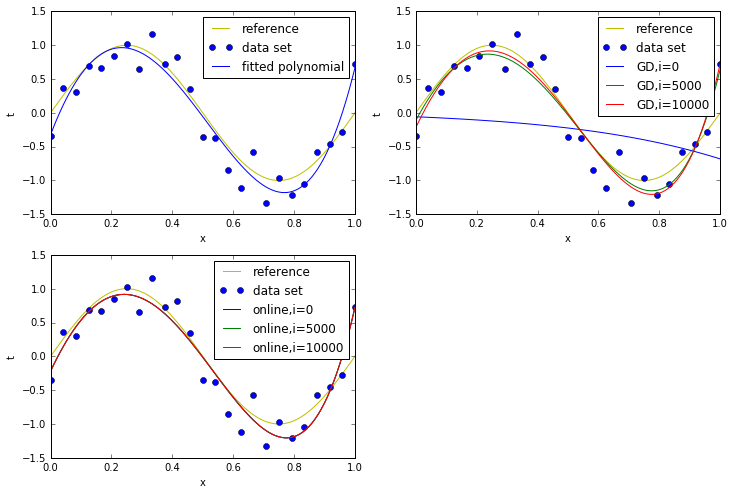

In [79]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
def genData(N = 25):
    x = np.linspace(0,1,N)
    y = np.sin(2*np.pi*x) + np.random.normal(scale = 0.25, size = N)
    return np.stack((x, y), axis=-1)
def getDesignMatrix(xs,M = 5):
    res = []
    for i in range(len(xs)):
        tmp = []
        for j in range(M):
            tmp.append(xs[i]**j)
        res.append(tmp)
    return np.array(res)
def basis(x,M = 5):
    res = []
    for i in range(M):
        res.append([x**i])
    return res

plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
# closed-form solution
data = genData()
rx = np.linspace(0,1,100)
ry = np.sin(2*np.pi*rx)
plt.plot(rx, ry,'y-', label='reference')
plt.plot(data[:,0],data[:,1],'bo',label='data set')
Phi = getDesignMatrix(data[:,0])
w_ML = np.linalg.inv(Phi.T.dot(Phi)).dot(Phi.T).dot(data[:,1].T)
plt.plot(rx,getDesignMatrix(rx).dot(w_ML),label='fitted polynomial')
plt.xlabel('x')
plt.ylabel('t')
plt.legend(loc='upper right')

plt.subplot(2,2,2)
# batch gradient descent
plt.plot(rx, ry,'y-', label='reference')
plt.plot(data[:,0],data[:,1],'bo',label='data set')
w_bat = np.zeros([Phi.shape[1]])
for i in range(10001):
    w_bat -= 0.05*Phi.T.dot(Phi.dot(w_bat)-data[:,1])
    if i % 5000 == 0:
        plt.plot(rx,getDesignMatrix(rx).dot(w_bat),label='GD,i='+str(i))
plt.legend(loc='upper right')
plt.xlabel('x')
plt.ylabel('t')

plt.subplot(2,2,3)
# on-line sequential
plt.plot(rx, ry,'y-', label='reference')
plt.plot(data[:,0],data[:,1],'bo',label='data set')
w_online = np.zeros([Phi.shape[1]])
for i in range(10001):
    idx = np.random.randint(0, data.shape[0]-1)
    w_online += 0.05*(data[idx,1] - Phi[idx,:].dot(w_online))*(Phi[idx,:])
    if i % 5000 == 0:
        plt.plot(rx,getDesignMatrix(rx).dot(w_bat),label='online,i='+str(i))
plt.legend(loc='upper right')
plt.xlabel('x')
plt.ylabel('t')

## 3.2 The Bias-Variance Decomposition
The phenomenon of over-fitting is really an unfortunate property of maximum likelihood and does not arise when we marginalize over parameters in a Bayesian setting. In Section 1.5, when we discussed decision theory for regression problems, we considered various loss functions each of which leads to a corresponding optimal prediction once we are given the conditinoal distribution $p(t|\mathbf{x})$. A popular choice is the squared loss function, for which the optimal prediction is given by the conditional expectation, which we denote by $h(\mathbf{x})$ and which is given by
$$h(\mathbf{x}) = \mathbb{E}[t|\mathbf{x}] = \int tp(t|\mathbf{x})dt$$

The expected loss $\mathbb{E}[L]$ has three components:
* (bias)^2: 
$$\int\{\mathbb{E}_\mathcal{D}[y(\mathbf{x};\mathcal{D})] - h(\mathbf{x})\}^2p(\mathbf{x})dx$$

* variance:
$$\int \mathbb{E}_\mathcal{D}[\{y(\mathbf{x};\mathcal{D})-\mathbb{E}_\mathcal{D}[y(\mathbf{x};\mathcal{D})]\}^2]p(\mathbf{x})d\mathbf{x}$$

* noise:
$$\int \{h(\mathbf{x})-t\}^2p(\mathbf{x},t)d\mathbf{x}dt$$

There is a trade-off between bias and variance and noise is non-reducible. Flexible (small regularization) models have low bias and high variance, and relatively rigid (large regularization) models have high bias and low variance.

## 3.3 Bayesian Linear Regression
Consider a single input variable $x$, a single target variable $t$ and a linear model of the form $y(x,\mathbf{w}) = w_0 + w_1x$. We generate synthetic data from $f(x,\mathbf{a}) = -0.3 + 0.5x$ by first choosing values of $x_n$ from the uniform distribution $U(x|-1,1)$, then evaluating $f(x_n,\mathbf{a})$, and finally adding Gaussian noise with standard deviation of 0.2 to obtain the target values $t_n$. We assume here that the noise variance is known ($\beta=(1/0.2)^2 = 25$). Similarly, we fix the parameter $\alpha = 2.0$.

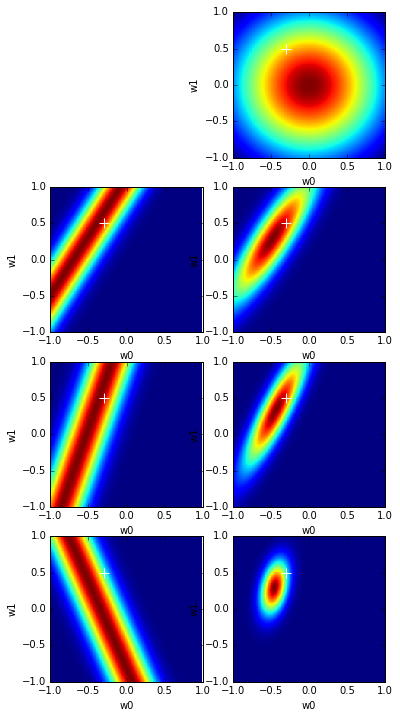

In [114]:
w1, w2 = np.meshgrid(np.arange(-1, 1, 0.01), np.arange(-1, 1, 0.01))
z = 1/np.pi*np.exp(-w1*w1-w2*w2)
plt.figure(figsize=(6,12))
plt.subplot(4,2,2)
plt.pcolormesh(w1,w2,z)
plt.scatter(-0.3,0.5,s=100,marker='+',color='white')
plt.xlim((-1,1))
plt.ylim((-1,1))
plt.xlabel('w0')
plt.ylabel('w1')

for i in [3,5,7]:
    plt.subplot(4,2,i)
    x = -1 + 2*np.random.rand()
    y = -0.3+0.5*x + np.random.normal(scale = 0.2)
    tmp = (y-(w1 + w2*x))/0.2
    likelihood = 1/np.sqrt(2*np.pi)*np.exp(-0.5*tmp*tmp)
    plt.pcolormesh(w1,w2,likelihood)
    plt.scatter(-0.3,0.5,s=100,marker='+',color='white')
    plt.xlim((-1,1))
    plt.ylim((-1,1))
    plt.xlabel('w0')
    plt.ylabel('w1')
    
    plt.subplot(4,2,i+1)
    z *= likelihood
    plt.pcolormesh(w1,w2,z)
    plt.scatter(-0.3,0.5,s=100,marker='+',color='white')
    plt.xlim((-1,1))
    plt.ylim((-1,1))
    plt.xlabel('w0')
    plt.ylabel('w1')

### Predictive distribution
The predictive distribution defined by
$$p(t|\mathsf{t},\alpha,\beta) = \int p(t|\mathbf{w},\beta)p(\mathbf{w}|\mathsf{t},\alpha,\beta)d\mathbf{w}$$
where the conditional distribution
$$p(t|\mathbf{x},\mathbf{w},\beta) = \mathcal{N}(t|\mathbf{w}^\top\phi(\mathbf{x}),\beta^{-1})$$
and the posterior weight distribution is given by
$$p(\mathbf{w}|\mathsf{t}) = \mathcal{N}(\mathbf{w}|\mathbf{m}_N,\mathbf{S}_N)$$
Therefore, the predictive distribution is given by
$$p(t|x,\mathsf{X},\mathsf{t}) = \mathcal{N}(t|m(x),s^2(x))$$
where
$$m(x) = \beta\phi(x)^\top\mathbf{S}\sum_{n=1}^N\phi(x_n)t_n$$
and 
$$s^2(x) = \beta^{-1} + \phi(x)^\top\mathbf{S}\phi(x)$$
Here the matrix $\mathbf{S}$ is given by
$$\mathbf{S}^{-1} = \alpha \mathbf{I} + \beta\sum_{n=1}^N\phi(x_n)\phi(x_n)^\top$$

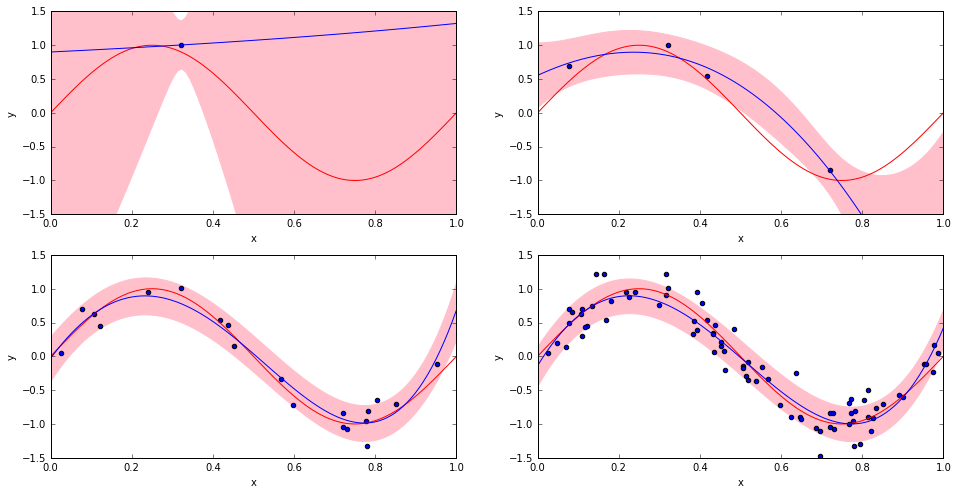

In [187]:
def genSample():
    x = np.random.rand()
    y = np.sin(2*np.pi*x)+np.random.normal(scale = 0.25)
    return x,y
def predictive(xs,xn,t):
    std = 0.25
    alpha = 0.005
    beta = 1/std/std
    m_tmp = np.zeros((5,1)) # default M = 5
    for i in range(len(xn)):
        m_tmp += np.array(basis(xn[i]))*t[i]
        
    m_res = np.zeros(xs.shape)
    s2_res = np.zeros(xs.shape)
    for i in range(len(xs)):
        basisx = np.array(basis(xs[i]))
        Sinv = alpha*np.eye(5)
        for j in xn:
            Sinv += beta*np.array(basis(j)).dot(np.array(basis(j)).T)
        S = np.linalg.inv(Sinv)
        m_res[i] = beta*(basisx.T).dot(S).dot(m_tmp)
        s2_res[i] = 1.0/beta + (basisx.T).dot(S).dot(basisx)
    return m_res, s2_res

xs = np.linspace(0,1,100)
xn = []
t = []
plt.figure(figsize=(16,8))
counter = 0
for n in range(81):
    x,y = genSample()
    xn.append(x)
    t.append(y)
    if len(xn) in [1,4,20,80]:
        m_res,s2_res = predictive(xs,xn,t)
        counter += 1
        plt.subplot(2,2,counter)
        plt.fill_between(xs, m_res-np.sqrt(s2_res), m_res+np.sqrt(s2_res),color='pink')
        plt.plot(xs,np.sin(2*np.pi*xs),'r-')
        plt.scatter(xn,t)
        plt.plot(xs,m_res)
        plt.xlim((0,1))
        plt.ylim((-1.5,1.5))
        plt.xlabel('x')
        plt.ylabel('y')